In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_kin_bicycle
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

from tqdm import tqdm



In [2]:
class NN(nn.Module):
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 3, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.output1 = nn.Linear(512, 8) 
        self.output2 = nn.Linear(512, 8) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5
v_max = 2
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [4]:
device = 'cpu'

def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -0.19, 0.19)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    v = uniform(n_batch, 0., 2.1)
    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.5*track_width*0.75)
    v_ub = penalty_v(v, v_max*0.95)

    xinit = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord)
mpc_T = 15
n_batch = 32
H_curve = 80
use_NN_curv = True

u_lower = torch.tensor([-2., -0.7]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([2., 0.7]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 1
lqr_iter = 10
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

8


In [5]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=1.,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,4] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,4] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,3] = p[:,3].clip(-70.)
    q2 = q.clone()
    return q2, p2

def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:4])
    q = torch.cat((q[:,:6], q_pen, q[:,6:]), dim=1)
    p = torch.cat((p[:,:6], p_pen, p[:,6:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch

In [6]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .0001*torch.ones(2).to(device)
p_penalty = torch.ones(2).to(device)

model = NN(H_curve)
opt = optim.Adam(model.parameters(), lr=8e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

8


In [7]:
for i in range(500):
    
    x_init = sample_xinit(n_batch).to(device)
    
    Q_batch, p_batch = inference_params(
        x_init, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

Batch: 0  Progression with MPC_T= 15 :  0.3011
Batch: 1  Progression with MPC_T= 15 :  0.7621
Batch: 2  Progression with MPC_T= 15 :  0.7188
[WARNING] pnqp warning: Did not converge
Batch: 3  Progression with MPC_T= 15 :  0.6875
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 4  Progression with MPC_T= 15 :  0.8124
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 5  Progression with MPC_T= 15 :  0.6002
Batch: 6  Progression with MPC_T= 15 :  0.6741
[WARNING] pnqp warning: Did not converge
Batch: 7  Progression with MPC_T= 15 :  -0.3449
Batch: 8  Progression with MPC_T= 15 :  0.6525
Batch: 9  Progression with MPC_T= 15 :  0.7068
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 10  Progression with MPC_T= 15 :  0.6974
Batch: 11  Progression with MPC_T= 15 :  0.7328
Batch: 12  Progression 

Batch: 122  Progression with MPC_T= 15 :  0.6314
Batch: 123  Progression with MPC_T= 15 :  0.5999
Batch: 124  Progression with MPC_T= 15 :  0.5494
Batch: 125  Progression with MPC_T= 15 :  0.5943
Batch: 126  Progression with MPC_T= 15 :  0.7301
[WARNING] pnqp warning: Did not converge
Batch: 127  Progression with MPC_T= 15 :  0.7106
Batch: 128  Progression with MPC_T= 15 :  0.67
Batch: 129  Progression with MPC_T= 15 :  0.7715
Batch: 130  Progression with MPC_T= 15 :  0.5871
Batch: 131  Progression with MPC_T= 15 :  0.7159
Batch: 132  Progression with MPC_T= 15 :  0.6345
[WARNING] pnqp warning: Did not converge
Batch: 133  Progression with MPC_T= 15 :  0.7088
Batch: 134  Progression with MPC_T= 15 :  0.7246
[WARNING] pnqp warning: Did not converge
Batch: 135  Progression with MPC_T= 15 :  0.7445
Batch: 136  Progression with MPC_T= 15 :  0.6673
[WARNING] pnqp warning: Did not converge
Batch: 137  Progression with MPC_T= 15 :  0.6125
[WARNING] pnqp warning: Did not converge
Batch: 138  P

Batch: 231  Progression with MPC_T= 15 :  0.7892
[WARNING] pnqp warning: Did not converge
Batch: 232  Progression with MPC_T= 15 :  0.7751
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 233  Progression with MPC_T= 15 :  0.6631
Batch: 234  Progression with MPC_T= 15 :  0.7488
[WARNING] pnqp warning: Did not converge
Batch: 235  Progression with MPC_T= 15 :  0.6694
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 236  Progression with MPC_T= 15 :  0.6571
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 237  Progression with MPC_T= 15 :  0.6965
Batch: 238  Progression with MPC_T= 15 :  0.7584
Batch: 239  Progression with MPC_T= 15 :  0.7827
[WARNING] pnqp warning: Did not converge
Batch: 240  Progression with MPC_T= 15 :  0.5949
Batch: 241  Progression with MPC_T= 15 :  0.699
[WARNING] pnqp warning: Did not converge
[WARNING] p

KeyboardInterrupt: 

In [8]:
N_test = 1
mpc_T_test = mpc_T

In [9]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.0)
d_pen = penalty_d(d, 0.5*track_width*0.75)

v = torch.tensor(0.01)
v_ub = penalty_v(v, v_max*0.95)

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, 0.01, sigma_0, 
                             sigma_diff, d_pen, v_ub]])

In [10]:
# Added here the bounds of U
u_lower_test = torch.tensor([-2., -.7]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([2., .7]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [11]:
N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=50,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.4,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)

    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,4] = x_simulated[i,0,0]
    x_simulated[i,0,5] = 0.

It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.  ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 2 x= [[0.01  0.02  0.001 0.11  0.01  0.    0.    0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 3 x= [[0.016 0.035 0.009 0.19  0.016 0.    0.    0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 4 x= [[0.025 0.052 0.025 0.277 0.025 0.    0.    0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 5 x= [[0.038 0.063 0.039 0.363 0.038 0.    0.    0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 6 x= [[0.056 0.072 0.055 0.447 0.056 0.    0.    0.   ]]
LQR Warning: All examples did not 

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 25 x= [[ 1.268 -0.187  0.391  1.831  1.268  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 26 x= [[ 1.512 -0.172  1.026  1.84   1.512  0.     0.     0.   ]]
[WARN

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 38 x= [[ 2.595  0.029 -0.04   1.883  2.595  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 39 x= [[ 2.689  0.024 -0.057  

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 70 x= [[5.861 0.024 0.036 1.894 5.861 0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 71 x= [[ 5.949  0.007 -0.148  1.901  5.949  0.     0.     0.13 ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 72 x= [[ 6.029 -0.026 -0.066  1.86   6.029  0.     0.

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 104 x= [[8.934 0.05  0.401 1.861 8.934 0.    0.    0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 105 x= [[9.025 0.097 0.195 1.872 9.025 0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 106 x= [[ 9.14   0.134 -0.012  1.863  9.14   0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 107 x= [[ 9.298  0.152 -0.362  1.879  9.298  0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNI

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 123 x= [[10.844 -0.064  0.041  1.862 10.844  0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 124 x= [[10.936 -0.057  0.077  1.867 10.936  0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 125 x= [[11.028 -0.044  0.131  1.876 11.028  0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 126 x= [[11.121 -0.034  0.105  1.881 11.121  0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad exa

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 150 x= [[ 13.705  -0.189   0.93    1.853  13.705   0.    108.087   0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 151 x= [[13.92  -0.134  1.467  1.783 13.92   0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 152 x= [[13.941 -0.058  1.286  1.746 13.941  0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 153 x= [[1.3982e+01 1.0000e-02 1.0190e+00 1.7750e+00 1.3982e+01 0.0000e+00
  0.0000e+00 0.0000e+00]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 154 x= [[14.047  0.074  0.698

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 179 x= [[ 1.604e+01 -1.740e-01 -1.000e-03  1.663e+00  1.604e+01  0.000e+00
   0.000e+00  0.000e+00]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 180 x= [[16.23  -0.187  0.522  1.716 16.23   0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] 

In [12]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [13]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


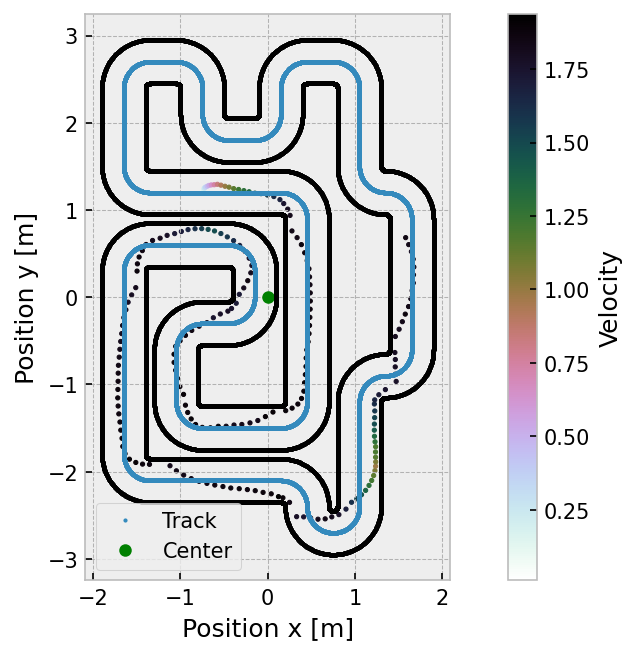

In [14]:
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

### Debug problem in a specific state with specific control

In [25]:
x_try = torch.tensor([[ 1.356, -0.138,  0.964,  1.036,  1.356,  0.,     0.,     0.   ]])

In [26]:
#x_try = torch.tensor([[4.4648e+00, 1.3147e-01, 1.2658e-01, 1.6995e+00, 4.4648e+00, 0.0000e+00,
#         2.4290e-05, 4.4661e-03, 1.2244e-04]])

In [27]:
q_test, p_test = model(curvs_test, x_try[:,1:4])
q_test = torch.cat((q_test[:,:6], q_penalty_batch, q_test[:,6:]), dim=1)
p_test = torch.cat((p_test[:,:6], p_penalty_batch, p_test[:,6:]), dim=1)

q2_test, p2_test = bound_params(q_test, p_test)

#p2_test[0,3] = -0.5

Q_test_batch, p_test_batch = cost_to_batch_NN(q2_test, p2_test, N_test, mpc_T_test) 

In [28]:
x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
        n_state, n_ctrl, mpc_T_test,
        u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
        lqr_iter=60,
        verbose=0,
        exit_unconverged=False,
        detach_unconverged=True,
        linesearch_decay=.4,
        max_linesearch_iter=10,
        grad_method=grad_method,
        eps=.5,
        n_batch=N_test,
    )(x_try, QuadCost(Q_test_batch, p_test_batch), dx)

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.


In [29]:
q2_test[0]

tensor([1.0000e-04, 1.3887e+01, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04],
       grad_fn=<SelectBackward0>)

In [30]:
p2_test[0]

tensor([  0.0000,   0.0000,   0.0000, -62.5197,   0.0000, -50.5911,   1.0000,
          1.0000, -70.0000,  -7.4363], grad_fn=<SelectBackward0>)

In [31]:
objs_mpc_test

tensor([-3113.2705], grad_fn=<CopySlices>)

In [32]:
u_mpc_test[0]

tensor([[ 1.1718, -0.5000]], grad_fn=<SelectBackward0>)

In [39]:
x_mpc_test[1,0]

tensor([ 0.2871, -0.0882, -0.0932,  0.6253,  0.2570,  0.0301,  0.0000,  0.0000],
       grad_fn=<SelectBackward0>)

In [40]:
q2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))**2 + p2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))

tensor([[ 6.6049e-06,  7.2251e-02,  8.4640e-07, -7.8857e+00,  6.6049e-06,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2228e+00, -3.1622e-02]],
       grad_fn=<AddBackward0>)

In [34]:
(q2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))**2 + p2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))).sum()

tensor(5.2632, grad_fn=<SumBackward0>)

In [41]:
p2_test

tensor([[  0.0000,   0.0000,   0.0000, -13.0128,   0.0000,  -8.8466,   1.0000,
           1.0000, -14.2250,   2.0384]], grad_fn=<CopySlices>)

In [46]:
q2_test

tensor([[1.0000e-04, 1.0000e+01, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
         1.0000e-04, 1.0000e-04, 8.6453e+01, 1.0000e-04]],
       grad_fn=<CloneBackward0>)

In [48]:
dx.forward(x_try, u_mpc_test[0])

tensor([[ 7.6424e+00, -3.9416e-01,  8.5236e+00,  4.4439e+00,  1.6539e-01,
          1.5927e-04]], grad_fn=<StackBackward0>)

In [34]:
p_test.shape

torch.Size([1, 11])

### Executing with casadi

In [31]:
N_sim_total = 40
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

control = casadi_control.CasadiControl(track_coord)

for i in range(1,N_sim_total):
      
    
    x_sim = x_simulated[i-1]
    print(x_sim)
        
    curvs_test = get_curve_hor_from_x(torch.tensor(x_sim).float(), track_coord, H_curve)
    q_test, p_test = model(curvs_test, torch.tensor(x_sim[:,1:4]).float())
    q_test = torch.cat((q_test[:,:6], q_penalty_batch, q_test[:,6:]), dim=1)
    p_test = torch.cat((p_test[:,:6], p_penalty_batch, p_test[:,6:]), dim=1)

    q2_test, p2_test = bound_params(q_test, p_test)

    Q_test_batch, p_test_batch = cost_to_batch_NN(q2_test, p2_test, N_test, mpc_T_test) 

            
 
    sol = control.mpc_casadi(q_test[0].detach().numpy(),
                             p_test[0].detach().numpy(),
                             x_sim,
                             mpc_T_test,
                             2,
                             2,
                             n_state,
                             n_ctrl,
                             track_width,
                             2.)
    
    u = sol[-n_ctrl*mpc_T_test:]
    x = sol[:-n_ctrl*mpc_T_test]
    u_mpc_test = u.reshape(mpc_T_test,n_ctrl)
    x_mpc_test = x.reshape(mpc_T_test+1,n_state-2)
        
    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,4] = x_simulated[i,0,0]
    x_simulated[i,0,5] = 0.

[[ 9.99999978e-03  0.00000000e+00 -0.00000000e+00  9.99999978e-03
   9.99999978e-03  0.00000000e+00  7.88897369e-03  7.88897369e-03
   2.27792785e-10]]
curv start
curv end
curv start
curv end
curv start
curv end


RuntimeError: .../casadi/core/sparsity.cpp:431: Assertion "x.size2()==y.size1()" failed:
Matrix product with incompatible dimensions. Lhs is 15x10 and rhs is 9x9.

In [ ]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [ ]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

ax.scatter(x_plot, y_plot, s=4, color='red')
#ax.scatter(0.1471, 0.8741, s=7, color='green')
#ax.scatter(0.4500, 0.5100, s=100, color='blue')



print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [125]:
ds = torch.arange(-1,1,0.01)

In [120]:
pens = 1000*softplus_op(-torch.tensor(ds)-0.5*track_width).numpy() + 1000*softplus_op(torch.tensor(ds)-0.5*track_width).numpy()

In [127]:
penalty_d(ds, 0.2, 10)

tensor([6.4000e+00, 6.2410e+00, 6.0840e+00, 5.9290e+00, 5.7760e+00, 5.6250e+00,
        5.4760e+00, 5.3290e+00, 5.1840e+00, 5.0410e+00, 4.9000e+00, 4.7610e+00,
        4.6240e+00, 4.4890e+00, 4.3560e+00, 4.2250e+00, 4.0960e+00, 3.9690e+00,
        3.8440e+00, 3.7210e+00, 3.6000e+00, 3.4810e+00, 3.3640e+00, 3.2490e+00,
        3.1360e+00, 3.0250e+00, 2.9160e+00, 2.8090e+00, 2.7040e+00, 2.6010e+00,
        2.5000e+00, 2.4010e+00, 2.3040e+00, 2.2090e+00, 2.1160e+00, 2.0250e+00,
        1.9360e+00, 1.8490e+00, 1.7640e+00, 1.6810e+00, 1.6000e+00, 1.5210e+00,
        1.4440e+00, 1.3690e+00, 1.2960e+00, 1.2250e+00, 1.1560e+00, 1.0890e+00,
        1.0240e+00, 9.6100e-01, 9.0000e-01, 8.4100e-01, 7.8400e-01, 7.2900e-01,
        6.7600e-01, 6.2500e-01, 5.7600e-01, 5.2900e-01, 4.8400e-01, 4.4100e-01,
        4.0000e-01, 3.6100e-01, 3.2400e-01, 2.8900e-01, 2.5600e-01, 2.2500e-01,
        1.9600e-01, 1.6900e-01, 1.4400e-01, 1.2100e-01, 1.0000e-01, 8.1000e-02,
        6.4000e-02, 4.9000e-02, 3.6000e-

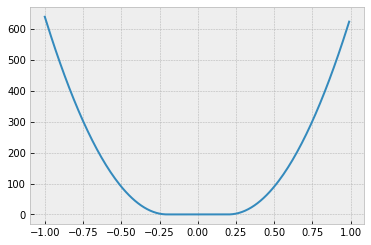

In [129]:
plt.plot(ds.numpy(), penalty_d(ds, 0.2, 1000).numpy())